In [1]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.signal import savgol_filter
import math
import boris_extraction as boris
import pandas as pd
from scipy.stats import sem
from scipy.stats import ranksums
from statistics import mean
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA
from statistics import StatisticsError


In [2]:
#to do

#event snippet and event length code caused issues

# test multirecording code
# specfically recording = name of object or object
# test PCA code
# write doc_strings for zscore and pca code  

# rearrange attributes of recordings vs event functions

# write code to add event dict to recordings 
# as well as subject per recording
# either as a batch process or individually (code for both) 

# add exporting functions for all data (collection) or some data (per recording) 
# add fishers exact test code somewhere 

# neaten/clean up EDA plot code - its a mess , maybe turn em into notebooks instead ? 

# figure out this equalize parameter
# potentially get rid of all options except user_defined 




In [3]:

def get_spiketrain(timestamp_array, timebin =1, sampling_rate=20000):
    """
    creates a spiketrain of ms time bins 
    each array element is the number of spikes recorded per ms
    
    Args (3 total):
        timestamp_array: numpy array, spike timestamp array
        timebin: int, default=1, timebin (ms) of resulting spiketrain
        sampling_rate: int, default=20000, sampling rate in Hz of the ephys recording
        
    Returns (1):
        spiketrain: numpy array, array elements are number of spikes per timebin
    """
    
    hz_to_timebin = int(sampling_rate*.001*timebin)
    spiketrain = np.histogram(timestamp_array, bins=np.arange(0, timestamp_array[-1], hz_to_timebin))[0]
    
    return spiketrain

def get_firing_rate(spiketrain, smoothing_window = 250, timebin=1):
    """
    calculates firing rate (spikes/second)
    
    Args (3 total, 1 required):
        spiketrain: numpy array, in timebin (ms) bins
        smoothing_window: int, default=250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, timebin (ms) of spiketrain

    Return (1):
        firing_rate: numpy array of firing rates in timebin sized windows
        
    """ 
    weights = np.ones(smoothing_window) / smoothing_window * 1000 / timebin 
    firing_rate = np.convolve(spiketrain, weights, mode='same')

    return firing_rate


def get_event_lengths(events):
    """
    calculates event lengths and longest event length

    Args (1):
        events:numpy array of [[start (ms), stop (ms)] x n events]

    Returns (2):
        max event length: int, longest event length in ms
        event_lengths: lst of ints, event lengths in ms
    """
    event_lengths = []
    for i in range(len(events[0])+1):
        event_length = int(events[i][1] - events[i][0])
        event_lengths.append(event_length)
    return max(event_lengths), event_lengths, mean(event_lengths)


def trim_event(event, max_event):
    """
    trims events to a given length
    Args (2 total):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        max_event: int, max length (s) of event desired

    Returns (1):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        with none longer than max_event
    """
    if event[1] - event[0] > (max_event*1000):
        event[1] = event[0]+(max_event*1000)
        event[0] = event[0]  
    return np.array(event)


def pre_event_window(event, baseline_window):
    """
    creates an event like object np.array[start(ms), stop(ms)] for
    baseline_window amount of time prior to an event

    Args (2 total):
        event: np.array[start(ms), stop(ms)]
        baseline_window: int, seconds prior to an event

    Returns (1):
        preevent: np.array, [start(ms),stop(ms)] baseline_window (s) before event
    """
    preevent = [event[0] - (baseline_window*1000)-1, event[0]-1]
    return np.array(preevent)


def max_events(unit_dict, max_event, pre_window, timebin = 1):
    """
    creates a dictionary with unit firing rates during events no longer
    than max_event (s) (all longer events will be trimmed) and start times
    adjusted to include pre_window time (s)

    Args (4 total):
        unit_dict: dict, unit id as keys, and values are spiketrains or firing rates 
        max_event: int, longest event length (s) returned (all longer events will be trimmed)
        pre_window: int, amount of preevent time (s) returned
        timebin: timebin (ms) of dict

    Returns (1):
        snippets_dict: dict, unit id as keys, values are spiketrains or firing rates during
        pre_window and up until max event 
    """
    
    snippets_dict = {}
    for unit in unit_dict.keys():
        events = unit_dict[unit]
        try:
            events = [event[0:int((pre_window + max_event)*1000/timebin)] for event in events]
        except IndexError:
            pass
        snippets_dict[unit] = events
    return snippets_dict


def get_unit_average_events(unit_event_snippets):
    unit_average_event = {}
    for unit in unit_event_snippets.keys():
        unit_average_event[unit] = np.mean(unit_event_snippets[unit], axis=0)
    return unit_average_event


class EphysRecording:
    """
    A class for an ephys recording after being spike sorted and manually curated using phy. 
    Ephys recording must have a phy folder. 

    Attributes:
        path: str, relative path to the phy folder
            formatted as: './folder/folder/phy'
        subject: str, subject id who was being recorded
        sampling_rate: int, sampling rate of the ephys device
            in Hz, standard in the PC lab is 20,000Hz
        timestamps_var: numpy array, all spike timestamps 
            of good and mua units (no noise unit-generated spikes)
        unit_array: numpy array, unit ids associated with each
            spike in the timestamps_var
        labels_dict: dict, keys are unit ids (str) and
            values are labels (str)
        unit_timestamps: dict, keys are unit ids (int), and
            values are numpy arrays of timestamps for all spikes 
            from "good" units only 
        spiketrain: np.array, spiketrain of number of spikes in a specified timebin
        unit_spiketrains: dict, spiketrains for each unit
            keys: str, unit ids
            values: np.array, number of spikes per specified timebin
        unit_firing_rates: dict, firing rates per unit
            keys: str, unit ids
            values: np.arrays, firing rate of unit in a specified timebin 
                    calculated with a specified smoothing window

    Methods: (all called in __init__)
        get_unit_labels: creates labels_dict
        get_spike_specs: creates timestamps_var and unit_array
        get_unit_timestamps: creates unit_timestamps dictionary
    """
    
    def __init__(self, path, sampling_rate=20000):
        """
        constructs all necessary attributes for the EphysRecording object
        including creating labels_dict, timestamps_var, and a unit_timstamps 
        dictionary 
        
        Arguments (2 total):
            path: str, relative path to the phy folder
                formatted as: './folder/folder/phy'
            sampling_rate: int, default=20000; sampling rate of 
                the ephys device in Hz
        Returns:
            None
        """
        self.path = path
        self.sampling_rate = sampling_rate
        self.zscored_events = {}
        self.wilcox_dfs = {}
        self.get_unit_labels()
        self.get_spike_specs()
        self.get_unit_timestamps()

    
    def get_unit_labels(self):
        """
        assigns self.labels_dicts as a dictionary 
        with unit id (str) as key and label as values (str)
        labels: 'good', 'mua', 'noise' 

        Arguments:
            None

        Returns:
            None
        """
        labels = 'cluster_group.tsv'
        with open(os.path.join(self.path, labels), 'r') as f:
            reader = csv.DictReader(f, delimiter='\t')
            self.labels_dict = {row['cluster_id']: row['group'] for row in reader}

    
    def get_spike_specs(self):
        """
        imports spike_time and spike_unit from phy folder
        deletes spikes from units labeled noise in unit and timestamp array
        and assigns self.timstamps_var (numpy array) as the remaining timestamps 
        and assigns self.unit_array (numpy array) as the unit ids associated
        with each spike
        
        Args:
            None
        
        Returns:
            None 
        """
        timestamps = 'spike_times.npy'
        unit = 'spike_clusters.npy'
        timestamps_var = np.load(os.path.join(self.path, timestamps))
        unit_array = np.load(os.path.join(self.path, unit))
        spikes_to_delete = []
        for spike in range(len(timestamps_var)): 
            if self.labels_dict[unit_array[spike].astype(str)] == 'noise':
                spikes_to_delete.append(spike)
        self.timestamps_var = np.delete(timestamps_var, spikes_to_delete)
        self.unit_array = np.delete(unit_array, spikes_to_delete)

    
    def get_unit_timestamps(self):
        """
        creates a dictionary of units to spike timestamps
        keys are unit ids (int) and values are spike timestamps for that unit (numpy arrays)
        and assigns dictionary to self.unit_timestamps
        
        Args:
            None
        
        Return:
            None
        """
        
        unit_timestamps = {}
        for spike in range(len(self.timestamps_var)): 
            if self.unit_array[spike] in unit_timestamps.keys():
                timestamp_list = unit_timestamps[self.unit_array[spike]] 
                timestamp_list = np.append(timestamp_list, self.timestamps_var[spike])
                unit_timestamps[self.unit_array[spike]] = timestamp_list
            else:
                unit_timestamps[self.unit_array[spike]] = self.timestamps_var[spike]
        
        self.unit_timestamps = unit_timestamps   
    

class SpikeAnalysis_SingleRecording:
    """
    A class for ephys statistics done on multiple event types
    an EphysRecording class instance 
    and an event dictionary
    where keys are event type names and values are arrays [[start (ms), stop(ms)]..]
    
    Attributes:
        event_dict: dict, dictionary of event names and event start and stop times
            key: str, name of the event 
            value: numpy array of [[start (ms), stop (ms)] x n events]
        event_types: lst of strs, from the keys of the event dict
        events: list of all start and stop times from event types 
        smoothing_window: int, default=250, window length in ms used to calculate firing rates
        timebin: int, default=1, bin size (in ms) for spike train and firing rate arrays
        ignore_freq: int, default=0, frequency in Hz that a good unit needs to fire at to be included in analysis
        longest_event: int, length of longest event (ms)
        event_lengths: lst, length of all events (ms)
        
    Methods: 
        get_whole_spiketrain: 
        get_unit_spiketrains: 
        get_unit_firing_rates: 
        get_event_snippets:
        get_unit_event_firing_rates:
        wilcox_baseline_v_event_stats:
        wilcox_baseline_v_event_plots:
    """
    def __init__(self, event_dict, recording, smoothing_window=250, timebin=1, ignore_freq=0.01):
        
        self.recording = recording
        self.event_dict = event_dict
        self.event_types = list(event_dict.keys())
        self.events = [value for sublist in event_dict.values() for value in sublist]
        self.smoothing_window = smoothing_window
        self.timebin = timebin
        self.ignore_freq = ignore_freq
        #maybe add avg per event type somewhere
        self.longest_event, self.event_lengths, self.mean_event_length = get_event_lengths(self.events)
        self.get_whole_spiketrain()
        self.get_unit_spiketrains()
        self.get_unit_firing_rates()

    def get_whole_spiketrain(self):
        """
        creates a spiketrain of ms time bins 
        each array element is the number of spikes recorded per ms
        
        Args (1 total):
            timestamp_array: numpy array, spike timestamp array
            
        Returns (1):
            spiketrain_ms_timebins: a numpy array 
                array elements are number of spikes per ms 
        """
       
        self.recording.spiketrain = get_spiketrain(self.recording.timestamps_var, self.recording.sampling_rate, self.timebin)
       
    def get_unit_spiketrains(self):  
        """
        Creates a dictionary and assigns it as self.unit_spiketrains
        where keys are 'good' unit ids (int) (not 'mua') that reach
        a threshold frequency, values are numpy arrays of 
        spiketrains in timebin sized bins
        
        Args:
            None
            
        Reutrns:
            None 
        """
        
        unit_spiketrains = {}
        freq_dict = {}
        for unit in self.recording.unit_timestamps.keys():
            if self.recording.labels_dict[str(unit)] == 'good':
                no_spikes = len(self.recording.unit_timestamps[unit])
                unit_freq = no_spikes/self.recording.timestamps_var[-1]*self.recording.sampling_rate
                freq_dict[unit] = unit_freq
                if unit_freq > self.ignore_freq:
                    unit_spiketrains[unit] = get_spiketrain(self.recording.unit_timestamps[unit], 
                                                            self.recording.sampling_rate, self.timebin)
        self.recording.unit_spiketrains = unit_spiketrains
        self.recording.freq_dict = freq_dict
    
    def get_unit_firing_rates(self):  
        """
        Calculates firing rates per unit,
        creates a dictionary and assigns it as self.unit_firing_rates
        the keys are unit ids (int) and values are firing rates for the
        unit (numpy array) in timebin sized bins 
        calculated using smoothing_window for averaging
        
        Args:
            none
            
        Returns:
            none
        """
       
        unit_firing_rates = {}
        for unit in self.recording.unit_spiketrains.keys():
            unit_firing_rates[unit] = get_firing_rate(self.recording.unit_spiketrains[unit], self.smoothing_window, self.timebin)
        self.recording.unit_firing_rates = unit_firing_rates
    
    def get_event_snippets(self, event, whole_recording, equalize, pre_window=0, post_window=0):
        """
        takes snippets of spiketrains or firing rates for events
        optional pre-event and post-event windows (s) may be included
        all events will be cut to equalize (s) length.
        If an event happens at the end of the recording and cannot fill
        the whole equalize + post_window time, that snippet will not be returned. 
    
        Args (5 total, 1 required): 
            whole_recording: numpy array, spiketrain or firing rates 
                for the whole recording, for population or for a single unit
            pre_window: int, default=0, seconds prior to start of event returned
            post_window: int, default=0, seconds after end of event returned
            equalize: {user_defined, 'max', 'average'}, equalizes lengths of events
                by padding with post event time or trimming event
                user_defined: float, makes all events user_defined (s) long   
                'max': makes all events as long as the longest event 
                'average': makes all events as long as the average event length 
            events:numpy array of [[start (ms), stop (ms)] x n events], 
                default=None in which case self.events is used
    
        Returns (1):
            event_snippets: a list of lists, where each list is a list of firing rates
                or spiketrains during an event including pre_window&post_windows, 
                accounting for equalize and timebins
        """
        if type(event) == str:
            events = self.event_dict[event]
        else:
            events = event
        event_snippets = []
        pre_window = math.ceil(pre_window*1000)
        post_window = math.ceil(post_window*1000)
        equalize = equalize*1000
        for i in range(events.shape[0]):
            pre_event = math.ceil((events[i][0] - pre_window)/self.timebin)
            post_event = math.ceil((events[i][0] + post_window + equalize)/self.timebin)
            event_snippet = whole_recording[pre_event:post_event]
            if len(event_snippet) == (equalize + post_window + pre_window)/self.timebin:
                #cutting events at end of recording
                event_snippets.append(event_snippet)
        return event_snippets
    
    def get_unit_event_firing_rates(self, event, equalize, pre_window = 0, post_window = 0):
        """
        returns firing rates for events per unit
    
        Args (6 total, 1 required):
            smoothing_window: int, default=250, smoothing average window (ms)
                min smoothing_window = 1 
            timebin: int, default 1, timebin in ms for firing rate array
            pre_window: int, default=0, seconds prior to start of event returned
            post_window: int, default=0, seconds after end of event returned
            equalize: {'max', average'}, default=False, equalizes lengths of events
                by padding with post event time or trimming event
                'max': makes all events as long as the longest event 
                'average': makes all events as long as the average event length 
            events:numpy array of [[start (ms), stop (ms)] x n events], 
                default=None in which case self.events is used
            
        Return (1):
            unit_event_firing_rates: dict, keys are unit ids (???),
            values are lsts of numpy arrays of firing rates per event
        """
        unit_event_firing_rates = {}
        for unit in self.recording.unit_firing_rates.keys():
            unit_event_firing_rates[unit] = self.get_event_snippets(event, self.recording.unit_firing_rates[unit], equalize, pre_window, post_window)
        return unit_event_firing_rates
       
        
    def wilcox_baseline_v_event_stats(self, event, baseline_window, equalize):
        """
        calculates wilcoxon signed-rank test for average firing rates of two windows: event vs baseline
        baseline used is an amount of time immediately prior to the event
        wilcoxon signed-rank test is applied to two sets of measurements:
        average firing rate per event, average firing rate per baseline
        
        Args (3 total, 1 required):
            baseline_window: int, length of baseline firing rate (s)
            max_event: int, default=None, max length of an event (s)
            equalize: Boolean, default=False, if True, equalizes lengths of each event to longest event
    
        Return (1):
            wilcoxon_df: pandas dataframe, columns are unit ids, 
            row[0] are wilcoxon statistics and row[1] are p values 
        
        """
        preevent_baselines = np.array([pre_event_window(event, baseline_window) for event in self.event_dict[event]])
        unit_preevent_firing_rates = self.get_unit_event_firing_rates(preevent_baselines, baseline_window, 0, 0)
        unit_event_firing_rates = self.get_unit_event_firing_rates(event, equalize, 0, 0)
        unit_averages = {}
        for unit in unit_event_firing_rates.keys():
            try:
                event_averages = [mean(event_fr) for event_fr in unit_event_firing_rates[unit]]
                preevent_averages = [mean(event_fr) for event_fr in unit_preevent_firing_rates[unit]]
                # cut preevent to events that have been cut
                min_length = min(len(event_averages), len(preevent_averages))
                preevent_averages = preevent_averages[:min_length]
                event_averages = event_averages[:min_length]
                unit_averages[unit] = [event_averages, preevent_averages]
            except StatisticsError as e:
                print(f'Unit {unit} has {len(self.recording.unit_timestamps[unit])} spikes')
        wilcoxon_stats = {}
        for unit in unit_averages.keys(): 
            wilcoxon_stats[unit] = wilcoxon(unit_averages[unit][0], unit_averages[unit][1], method = 'approx')
        wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_stats)
        wilcoxon_df.index = ['Wilcoxon Stat', 'p value']
        return wilcoxon_df

    def wilcox_baseline_v_event_plots(self, wilcoxon_df, event, baseline_window, equalize, title, p_value=None, units=None):
        """
        plots event triggered average firing rates for units
        all events need to be the same length

        Args(3 total, 1 required):
            title: str, title of figure
            p_value: int, default=None, all p values less than will be plotted
            units: lst, default=None, list of unit ids (ints) to be plotted

        Returns:
            none
        """ 
        units_to_plot = []
        if p_value is not None:
            for unit in wilcoxon_df.columns.tolist():
                if wilcoxon_df[unit][1] < p_value:
                      units_to_plot.append(unit)
        else:
            if units is None:
                units_to_plot = wilcoxon_df.columns.tolist()
            else:
                units_to_plot = units
        no_plots = len(units_to_plot)
        height_fig = math.ceil(no_plots/3)
        i = 1
        plt.figure(figsize=(20,4*height_fig))
        unit_event_firing_rates = self.get_unit_event_firing_rates(event, equalize, baseline_window, 0)
        for unit in units_to_plot:
            mean_arr = np.mean(unit_event_firing_rates[unit], axis=0)
            sem_arr = sem(unit_event_firing_rates[unit], axis=0)
            p_value = wilcoxon_df[unit][1]
            x = np.linspace(start=-baseline_window,stop=equalize,num=len(mean_arr))
            plt.subplot(height_fig,3,i)
            plt.plot(x, mean_arr, c= 'b')
            plt.axvline(x=0, color='r', linestyle='--')
            plt.fill_between(x, mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
            plt.title(f'Unit {unit} Average (p={p_value})')
            i+=1
        plt.suptitle(title)
        plt.show()

    def wilcoxon_event_v_event_stats(self, event1, event2, equalize):
        """
        calculates wilcoxon rank-sum test for average firing rates of two windows: event1 vs event2
        equal number of events (and thus averages) are compared such that the first
        events of event
        wilcoxon signed-rank test is applied to two sets of measurements:
        average firing rate per event, average firing rate per baseline
        
        Args (3 total, 1 required):
            baseline_window: int, length of baseline firing rate (s)
            max_event: int, default=None, max length of an event (s)
            equalize: {'max', average'}, default=False, equalizes lengths of events
                by padding with post event time or trimming event
                'max': makes all events as long as the longest event 
                'average': makes all events as long as the average event length 
    
        Return (1):
            wilcoxon_df: pandas dataframe, columns are unit ids, 
            row[0] are wilcoxon statistics and row[1] are p values 
        
        """
        unit_event1_firing_rates = self.get_unit_event_firing_rates(event1, equalize, 0, 0)
        unit_event2_firing_rates = self.get_unit_event_firing_rates(event2, equalize, 0, 0)
        unit_averages = {}
        for unit in unit_event1_firing_rates.keys():
            try:
                event1_averages = [mean(event) for event in unit_event1_firing_rates[unit]]
                event2_averages = [mean(event) for event in unit_event2_firing_rates[unit]]
                unit_averages[unit] = [event1_averages, event2_averages]
            except StatisticsError as e:
                print(f'Unit {unit} has {len(self.recording.unit_timestamps[unit])} spikes')
        wilcoxon_stats = {}
        for unit in unit_averages.keys(): 
            wilcoxon_stats[unit] = ranksums(unit_averages[unit][0], unit_averages[unit][1])
        wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_stats)
        wilcoxon_df.index = ['Wilcoxon Stat', 'p value']
        return wilcoxon_df
    
    def wilcox_event_v_event_plots(self, wilcoxon_df, event1, event2, baseline_window, equalize, title, p_value=None, units=None):
        """
        plots event triggered average firing rates for units
        all events need to be the same length

        Args(3 total, 1 required):
            title: str, title of figure
            p_value: int, default=None, all p values less than will be plotted
            units: lst, default=None, list of unit ids (ints) to be plotted

        Returns:
            none
        """ 
        units_to_plot = []
        if p_value is not None:
            for unit in wilcoxon_df.columns.tolist():
                if wilcoxon_df[unit][1] < p_value:
                      units_to_plot.append(unit)
        else:
            if units is None:
                units_to_plot = wilcoxon_df.columns.tolist()
            else:
                units_to_plot = units
        no_plots = len(units_to_plot)
        height_fig = math.ceil(no_plots/3)
        i = 1
        plt.figure(figsize=(20,4*height_fig))
        unit_event1_firing_rates = self.get_unit_event_firing_rates(event1, equalize, baseline_window, 0)
        unit_event2_firing_rates = self.get_unit_event_firing_rates(event2, equalize, baseline_window, 0)
        for unit in units_to_plot:
            mean1_arr = np.mean(unit_event1_firing_rates[unit], axis=0)
            sem1_arr = sem(unit_event1_firing_rates[unit], axis=0)
            mean2_arr = np.mean(unit_event2_firing_rates[unit], axis=0)
            sem2_arr = sem(unit_event2_firing_rates[unit], axis=0)
            p_value = wilcoxon_df[unit][1]
            x = np.linspace(start=-baseline_window,stop=equalize,num=len(mean1_arr))
            plt.subplot(height_fig,3,i)
            plt.plot(x, mean1_arr, c= 'b', label = event1)
            plt.fill_between(x, mean1_arr-sem1_arr, mean1_arr+sem1_arr, alpha=0.2)
            plt.plot(x, mean2_arr, c= 'k', label = event2)
            plt.fill_between(x, mean2_arr-sem2_arr, mean2_arr+sem2_arr, alpha=0.2, color = 'k')
            plt.axvline(x=0, color='r', linestyle='--')
            plt.title(f'Unit {unit} Average (p={p_value})')
            plt.legend()
            i+=1
        plt.suptitle(title)
        plt.show()

    def get_zscore(self, event, baseline_window, equalize):
        """
        Calculates zscored event average firing rates per unit including a baseline window (s).
        Takes in an event and returns a dictionary of unit ids to z scored
        averaged firing rates. 

        Args(3 total, 3 required):
            event: str, event type whose average firing rates are being z-scored
            baseline_window: int, length (s) of time prior to event onset to be included in 
                             calculations
            equalize: float, length (s) of events used by padding with post event time
                or trimming events all to equalize (s) long

        Returns(1):
            zscored_events: dict, of units to z scored average event firing rates
                            keys: str, unit ids
                            values: np.array, average z scared firing rates
        """
        preevent_baselines = np.array([pre_event_window(event, baseline_window) for event in self.event_dict[event]])
        unit_event_firing_rates = self.get_unit_event_firing_rates(event, (equalize+baseline_window), baseline_window, 0)
        unit_preevent_firing_rates = self.get_unit_event_firing_rates(preevent_baselines, baseline_window, 0, 0)
        zscored_events = {}
        for unit in unit_event_firing_rates:
            #calculate average event across all events per unit
            event_average = np.mean(unit_event_firing_rates[unit], axis = 0)
            #one average for all preevents 
            preevent_average = np.mean(unit_preevent_firing_rates[unit], axis = 0)
            mew = np.mean(preevent_average)
            sigma = np.std(preevent_average)
            if mew + sigma != 0:
                zscored_event = [(event_bin - mew)/sigma for event_bin in event_average]
                zscored_events[unit] = zscored_event
        return zscored_events
        
    def get_zcore_plot(self, zscored_events, baseline_window, equalize, title):
        """
        plots z-scored average event firing rate for the population of good units with SEM 
        and the z-scored average event firing rate for each good unit individually.
        Event plotted is the event that was used to create the argument zscored_events

        Args (4 total, 4 required):
            zscored_events: dict; keys: str, unit ids, value: z-scored event average firing rate
                            it is the return value of get_zscore
            baseline_window: int, length (s) of time prior to event onset plotted
            equalize: int, length (s) of event plotted
            title: str, title of plot
        
        Return:
            none    
        """
        plt.figure(figsize=(20,6))
        zscored_unit_event_firing_rates = zscored_events
        zscore_pop = np.array(list(zscored_unit_event_firing_rates.values()))
        mean_arr = np.mean(zscore_pop, axis=0)
        sem_arr = sem(zscore_pop, axis=0)
        x = np.linspace(start=-baseline_window,stop=equalize,num=len(mean_arr))
        plt.subplot(1,2,1)
        plt.plot(x, mean_arr, c= 'b')
        plt.axvline(x=0, color='r', linestyle='--')
        plt.fill_between(x, mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
        plt.title('Population z-score')
        plt.subplot(1,2,2)
        for unit in zscored_unit_event_firing_rates.keys():
            plt.plot(x, zscored_unit_event_firing_rates[unit], linewidth = .5)
            plt.axvline(x=0, color='r', linestyle='--')
            plt.title('Unit z-score')
        plt.suptitle(f'{title} Z-scored average')
        plt.show()        

    def PCA_trajectories(self, equalize, pre_window, post_window = 0):
        """
        calculates a PCA matrix (n_components = 3) where each data point represent a timebin 
        PCA space is calculated from a matrix of all units and all timebins 
        from every type of event in event dict.
        PCA_key is a numpy array of strings, whose index correlates with event
        type for that data point of the same index for all PCs in the PCA_matrix
        PCA_matrix is assigned to self.PCA_matrix and the key is assigned
        as self.PCA_key. 

        Args (3 total, 2 required):
            equalize: int, length (s) of event transformed by PCA 
            pre_window: int, length (s) of time prior to event onset included in PCA
            post_window: int, default=0, length(s) of time after equalize (s) included in PCA
        
        Returns:
            none

        """
        PCA_matrix_dict = {}
        PCA_key_dict = {}
        for unit in self.recording.unit_firing_rates.keys():
            first_event = True
            for event in self.event_dict.keys(): 
                unit_event_firing_rates = self.get_unit_event_firing_rates(event, equalize, pre_window, post_window)
                unit_event_average = get_unit_average_events(unit_event_firing_rates) 
                if first_event:
                    PCA_matrix_dict[unit] = unit_event_average[unit]
                    PCA_key_dict[unit] = [event] * int((equalize + pre_window + post_window) * 1000 / self.timebin)
                    first_event = False
                else:
                    PCA_matrix_dict[unit] = np.concatenate((PCA_matrix_dict[unit], unit_event_average[unit]), axis = 0)
                    next_event_key = [event] * int((equalize + pre_window + post_window) * 1000 / self.timebin)
                    PCA_key_dict[unit] = np.concatenate((PCA_key_dict[unit], next_event_key), axis = 0)
        PCA_matrix = np.array([v for v in PCA_matrix_dict.values()])
        PCA_matrix = np.transpose(PCA_matrix)
        PCA_key = np.array([v for v in PCA_key_dict.values()])
        PCA_key = PCA_key[0]
        pca = PCA(n_components=3)
        transformed_matrix = pca.fit_transform(PCA_matrix)
        self.PCA_matrix = transformed_matrix
        self.PCA_key = PCA_key
        self.PCA_equalize = equalize
        self.PCA_pre_window = pre_window
        self.PCA_post_window = post_window

    def PCA_EDA_plot(self):
        """
        Plots PCA trajectories calculated in PCA_trajectories using the same
        pre window, post window, and equalize parameters. Each event type is
        a different color. Preevent start is signified by a square, onset of behavior 
        signified by a triangle, and the end of the event is signified by a circle. 
        If post-event time is included that end of post event time is signified by a diamond. 

        Args:
            none
        
        Returns:
            none
        """
        post_window = self.PCA_post_window
        pre_window = self.PCA_pre_window
        equalize = self.PCA_equalize
        event_lengths = int((equalize + pre_window + post_window) * 1000 / self.timebin)
        event_end = int((equalize +pre_window) * 1000 / self.timebin)
        pre_window = pre_window * 1000 / self.timebin
        post_window = post_window * 1000 / self.timebin
        colors_dict = plt.cm.colors.CSS4_COLORS
        colors = list(colors_dict.values())
        col_counter = 10
        for i in range(0,len(self.PCA_key),event_lengths):
            event_label = self.PCA_key[i]
            onset = int(i+pre_window -1)
            end = int(i + event_end -1)
            post = int(i+event_lengths - 1 )
            plt.scatter(self.PCA_matrix[i:i+event_lengths, 0], 
                        self.PCA_matrix[i:i+event_lengths, 1],
                        label = event_label,
                        s = 5, c=colors[col_counter])
            plt.scatter(self.PCA_matrix[i,0], self.PCA_matrix[i,1],
                        marker = 's', s = 100, c = 'w', edgecolors=colors[col_counter])
            plt.scatter(self.PCA_matrix[onset, 0], self.PCA_matrix[onset, 1],
                        marker = '^', s = 150, c = 'w', edgecolors=colors[col_counter])
            plt.scatter(self.PCA_matrix[end,0], self.PCA_matrix[end,1],
                        marker = 'o', s = 100, c = 'w', edgecolors=colors[col_counter])
            if post_window != 0:
                plt.scatter(self.PCA_matrix[post,0], self.PCA_matrix[post,1],
                        marker = 'D', s = 100, c = 'w', edgecolors=colors[col_counter])
            col_counter +=1
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        if post_window !=0:    
            plt.title('Preevent = square, Onset = triangle, End of event = circle, Post event = Diamond')
        else:
            plt.title('Preevent = square, Onset = triangle, End of event = circle')
        plt.show()

    








In [4]:
random_phase3 = EphysRecording("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230809_103121_1_merged.rec\\phy")
p3d3_1_1 = EphysRecording("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230811_101635_1_merged.rec\\phy")



In [25]:

boris_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230809_103121_1_merged.rec\\20230809_103121_1.1_1t1bL_p3d1.xlsx")
p3d3_1_1_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230811_101635_1_merged.rec\\1.1_p3d3.xlsx")
p3d3_1_1_df = p3d3_1_1_df[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_1_1_df = p3d3_1_1_df[p3d3_1_1_df['Start (s)'] > 1903]
boris_df = boris_df[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_df = boris_df[boris_df['Start (s)'] > 1931.4]
first10min_1_1_df = p3d3_1_1_df[p3d3_1_1_df['Start (s)'] < 601]
first10min_1_1_df
familiarization_1_1_df = p3d3_1_1_df[(p3d3_1_1_df['Start (s)'] < 1208) & (p3d3_1_1_df['Start (s)'] > 608)]
ITI_1_1_df = p3d3_1_1_df[(p3d3_1_1_df['Start (s)'] > 1221) & (p3d3_1_1_df['Start (s)'] < 1809)]

In [26]:
novel_1_1_array = boris.get_behavior_bouts(last10min_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
fam_1_1_array = boris.get_behavior_bouts(last10min_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cagemate_1_1_array = boris.get_behavior_bouts(last10min_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
empty_1_1_array = boris.get_behavior_bouts(last10min_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
cup3_1_1_array = boris.get_behavior_bouts(first10min_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cup4_1_1_array = boris.get_behavior_bouts(first10min_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup1_1_1_array = boris.get_behavior_bouts(first10min_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cup2_1_1_array = boris.get_behavior_bouts(first10min_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
famcup3_1_1_array = boris.get_behavior_bouts(familiarization_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
famfam_1_1_array = boris.get_behavior_bouts(familiarization_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
famcup1_1_1_array = boris.get_behavior_bouts(familiarization_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
famcup2_1_1_array = boris.get_behavior_bouts(familiarization_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
ITIcup3_1_1_array = boris.get_behavior_bouts(ITI_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
ITIfamcup_1_1_array = boris.get_behavior_bouts(ITI_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
ITIcup1_1_1_array = boris.get_behavior_bouts(ITI_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
ITIcup2_1_1_array = boris.get_behavior_bouts(ITI_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)


In [7]:
novel_array = boris.get_behavior_bouts(last10min_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
fam_array = boris.get_behavior_bouts(last10min_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
cagemate_array = boris.get_behavior_bouts(last10min_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
empty_array = boris.get_behavior_bouts(last10min_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)

In [8]:
events = {'novel':novel_array, 'familiar':fam_array, 'cagemate':cagemate_array, 'empty':empty_array}
phase3_timebin_tester = SpikeAnalysis_SingleRecording(events, random_phase3, 100, 100, .05)


In [27]:
events_1_1 = { 'cup 1':cup1_1_1_array, 'cup 2':cup2_1_1_array, 'cup 3':cup3_1_1_array, 'cup 4': cup4_1_1_array, 'fam cup 1':famcup1_1_1_array, 'fam cup 2': famcup2_1_1_array, 'fam cup 3':famcup3_1_1_array, 'first fam': famfam_1_1_array, 'ITI cup 1':ITIcup1_1_1_array, 'ITI cup 2': ITIcup2_1_1_array, 'ITI cup 3': ITIcup3_1_1_array, 'ITI fam cup':ITIfamcup_1_1_array, 'cagemate':cagemate_1_1_array,'empty':empty_1_1_array, 'novel':novel_1_1_array,'familiar':fam_1_1_array}
analysis_1_1 = SpikeAnalysis_SingleRecording(events_1_1, p3d3_1_1, 100, 100, .05)

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


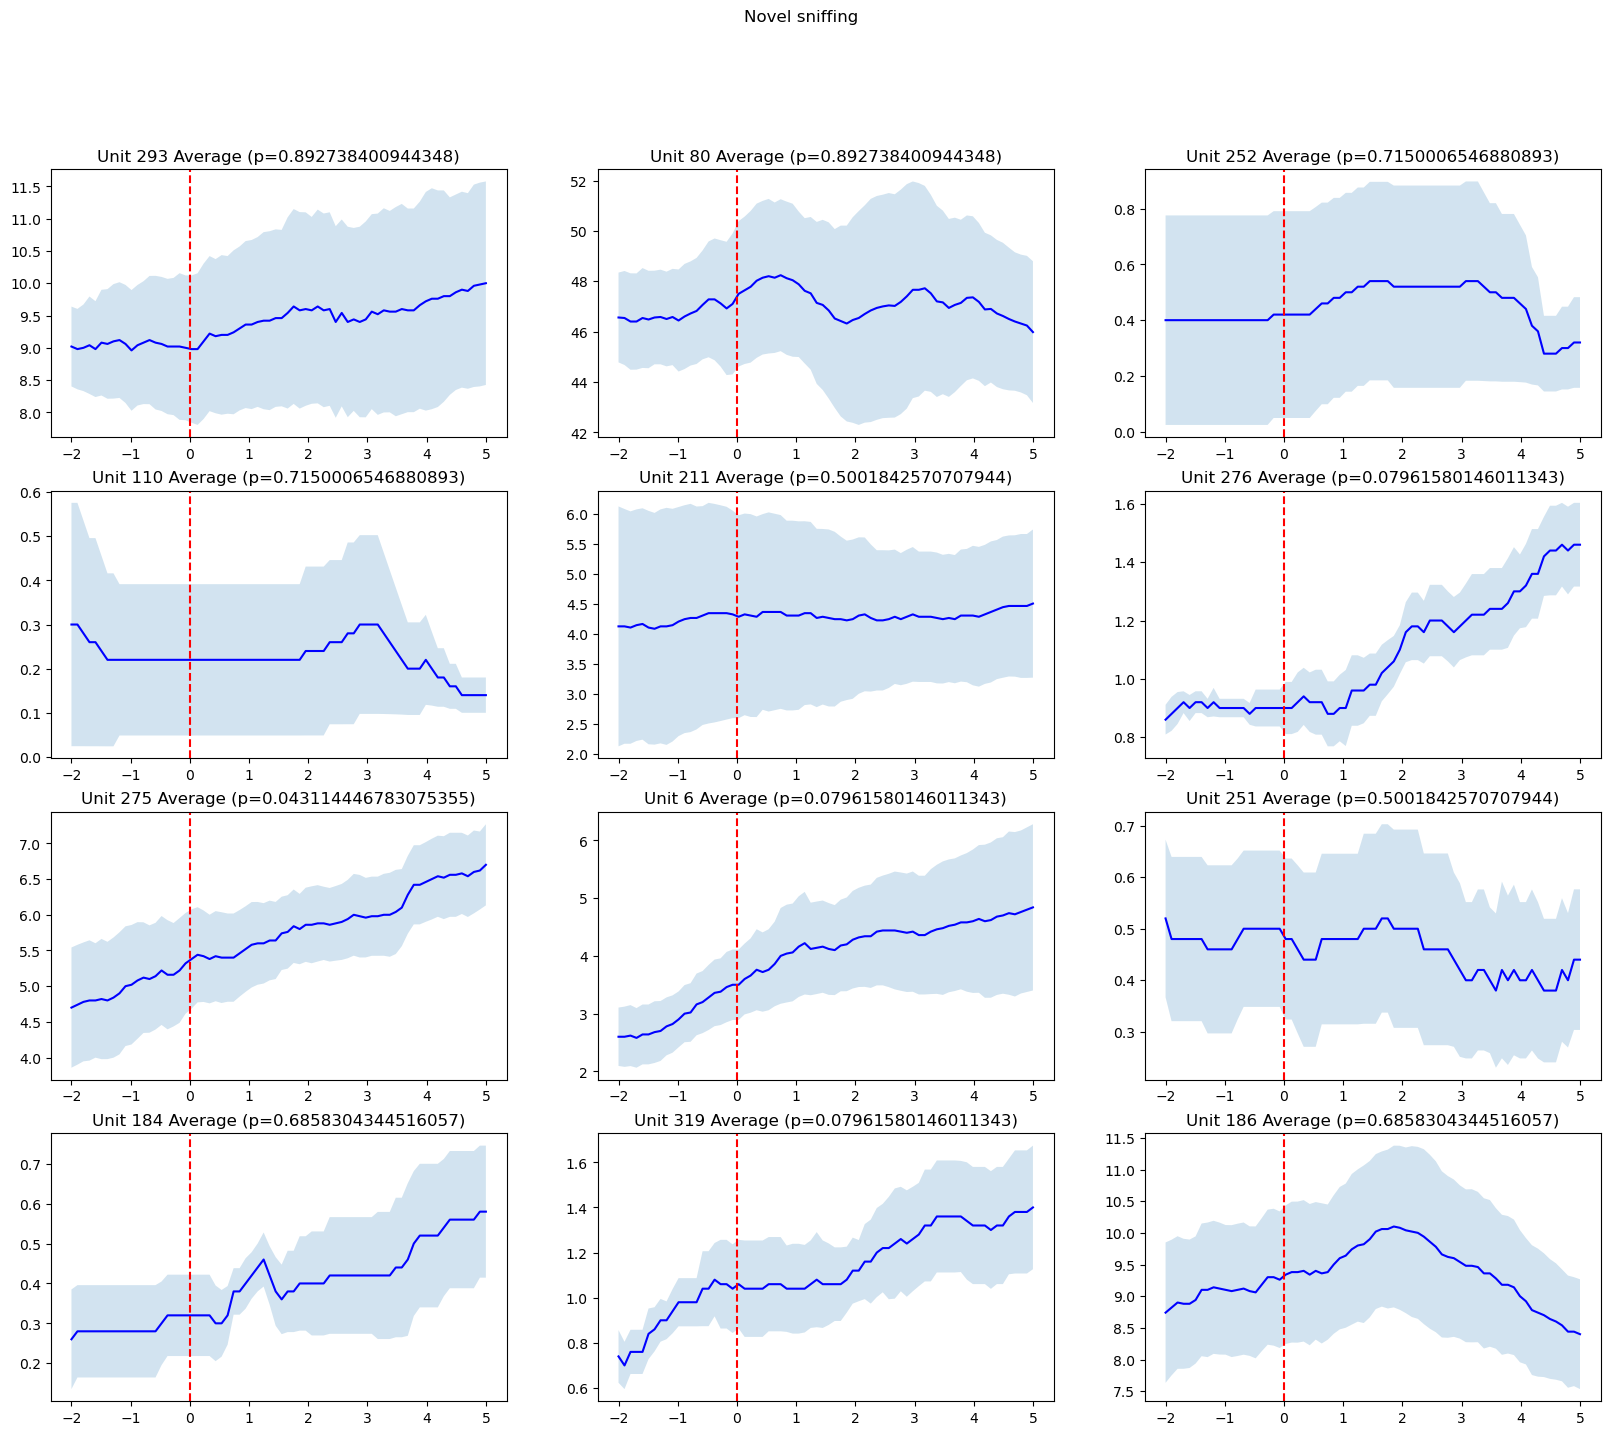

In [10]:
novel_wilcox_df = phase3_timebin_tester.wilcox_baseline_v_event_stats('novel',2, 5)
phase3_timebin_tester.wilcox_baseline_v_event_plots(wilcoxon_df=novel_wilcox_df, event='novel',baseline_window=2, equalize = 5, title='Novel sniffing')

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


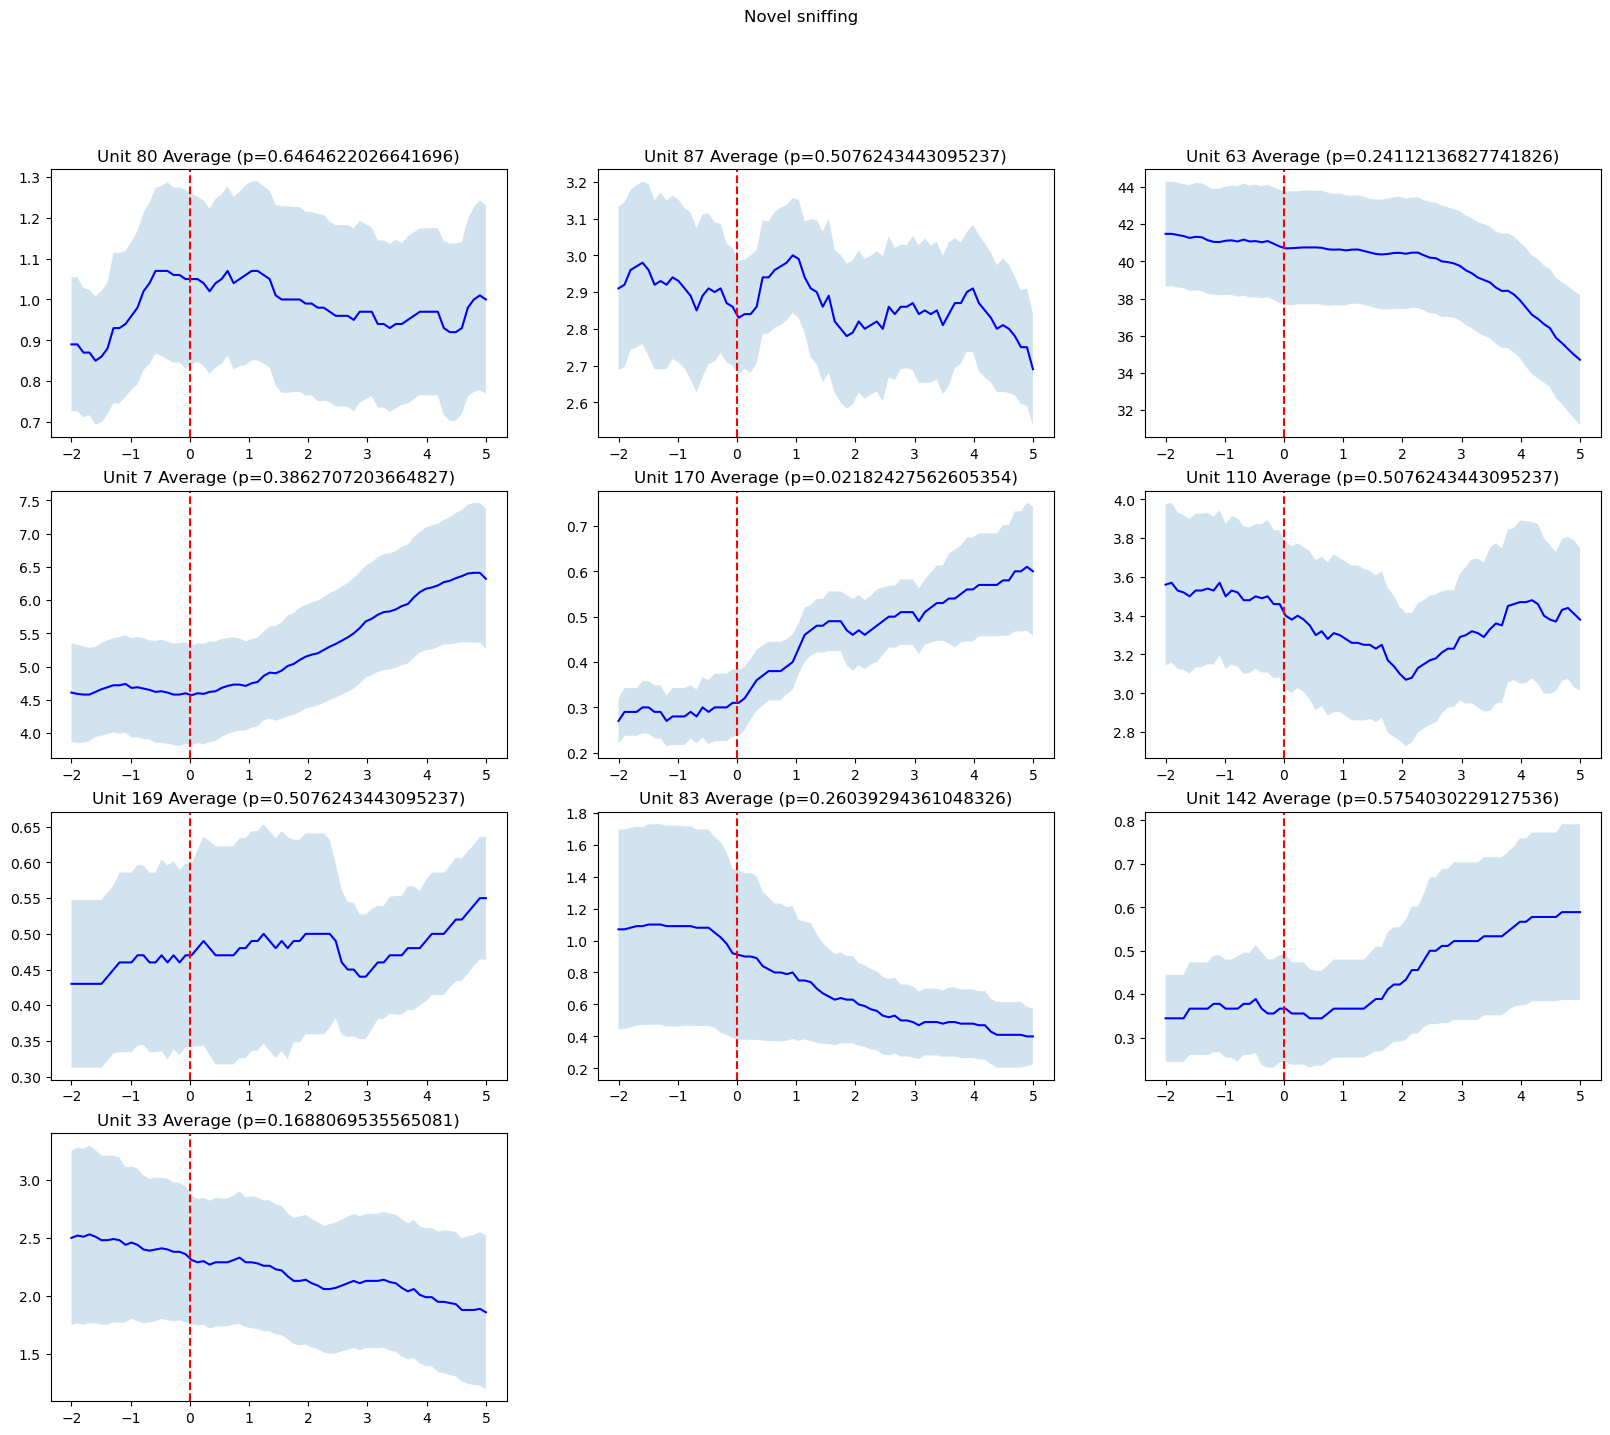

In [11]:
novel_wilcox_1_1_df = analysis_1_1.wilcox_baseline_v_event_stats('novel',2, 5)
analysis_1_1.wilcox_baseline_v_event_plots(wilcoxon_df=novel_wilcox_1_1_df, event='novel',baseline_window=2, equalize = 5, title='Novel sniffing')

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


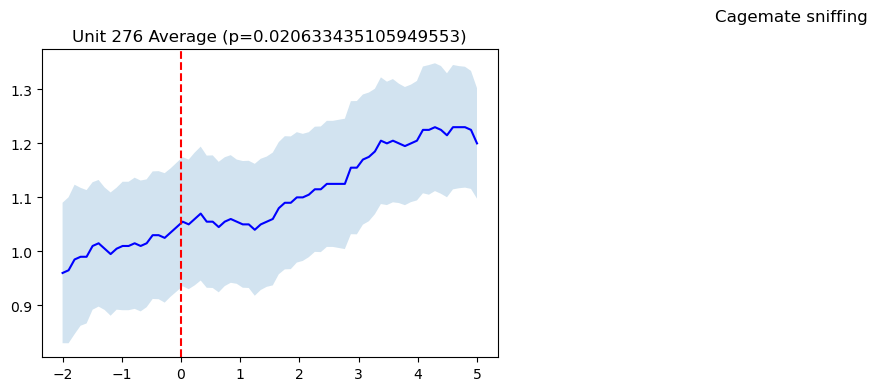

In [12]:

cagemate_wilcox_df = phase3_timebin_tester.wilcox_baseline_v_event_stats('cagemate', 2, 5)
phase3_timebin_tester.wilcox_baseline_v_event_plots(cagemate_wilcox_df, 'cagemate',2,5,'Cagemate sniffing', p_value=.1)


In [13]:
familiar_wilcox_df = phase3_timebin_tester.wilcox_baseline_v_event_stats('familiar', 2, 5)
phase3_timebin_tester.wilcox_baseline_v_event_plots(familiar_wilcox_df,'familiar',2,5,'familiar sniffing', p_value=.11)

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


<Figure size 2000x0 with 0 Axes>

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


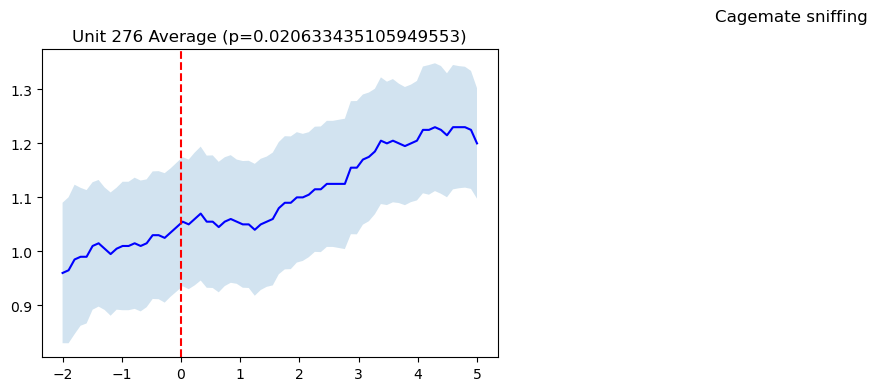

In [14]:
wilcox_cagemate_df = phase3_timebin_tester.wilcox_baseline_v_event_stats('cagemate',2,5)
phase3_timebin_tester.wilcox_baseline_v_event_plots(wilcox_cagemate_df,'cagemate',2,5,'Cagemate sniffing', p_value=.1)

In [15]:
wilcox_novel_vs_cagemate = phase3_timebin_tester.wilcoxon_event_v_event_stats('novel', 'cagemate', 2)
wilcox_fam_vs_cagemate = phase3_timebin_tester.wilcoxon_event_v_event_stats('familiar', 'cagemate', 5)

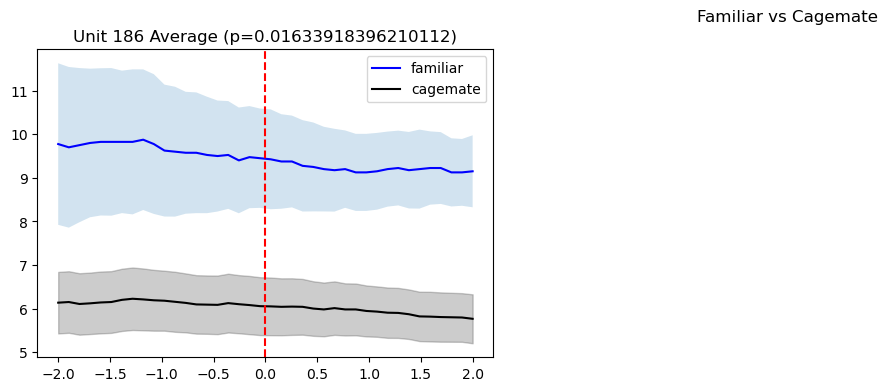

In [16]:
phase3_timebin_tester.wilcox_event_v_event_plots(wilcox_fam_vs_cagemate, 'familiar', 'cagemate', 2, 2, 'Familiar vs Cagemate', p_value=.1)

In [17]:
zscored_events = phase3_timebin_tester.get_zscore('familiar', 2, 5)

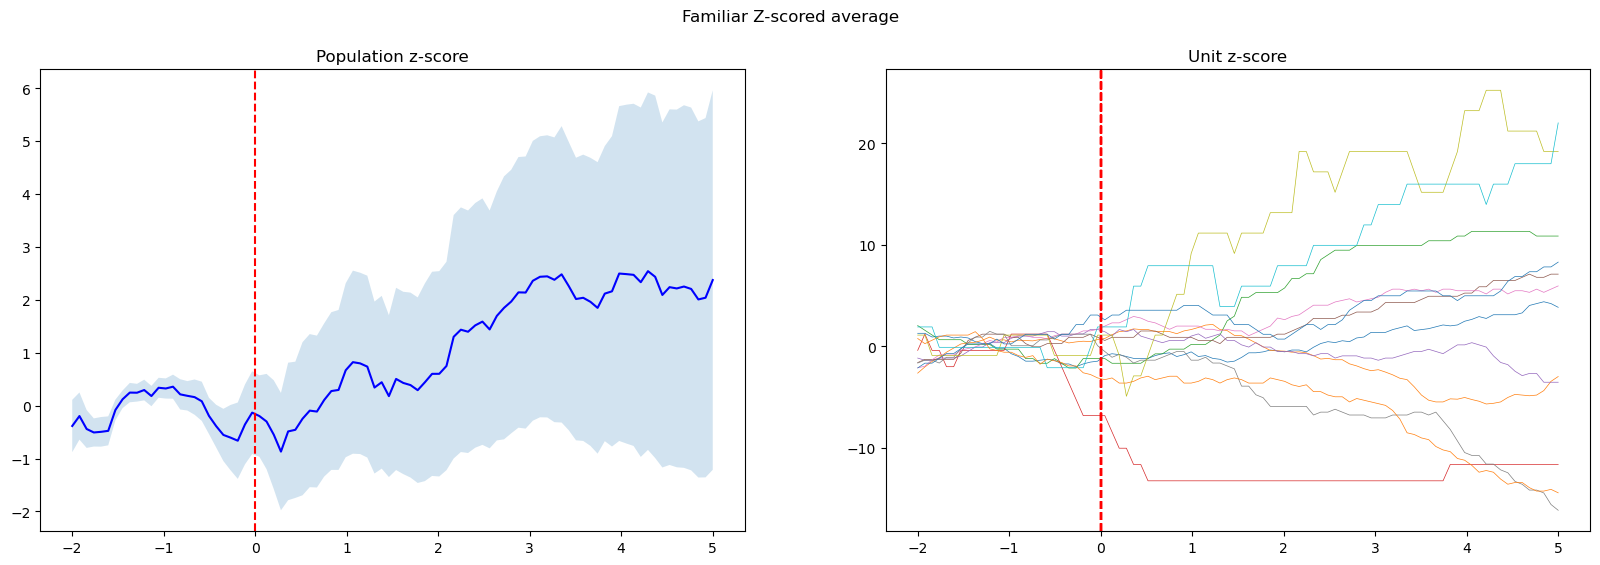

In [18]:
phase3_timebin_tester.get_zcore_plot(zscored_events, 2, 5, "Familiar")

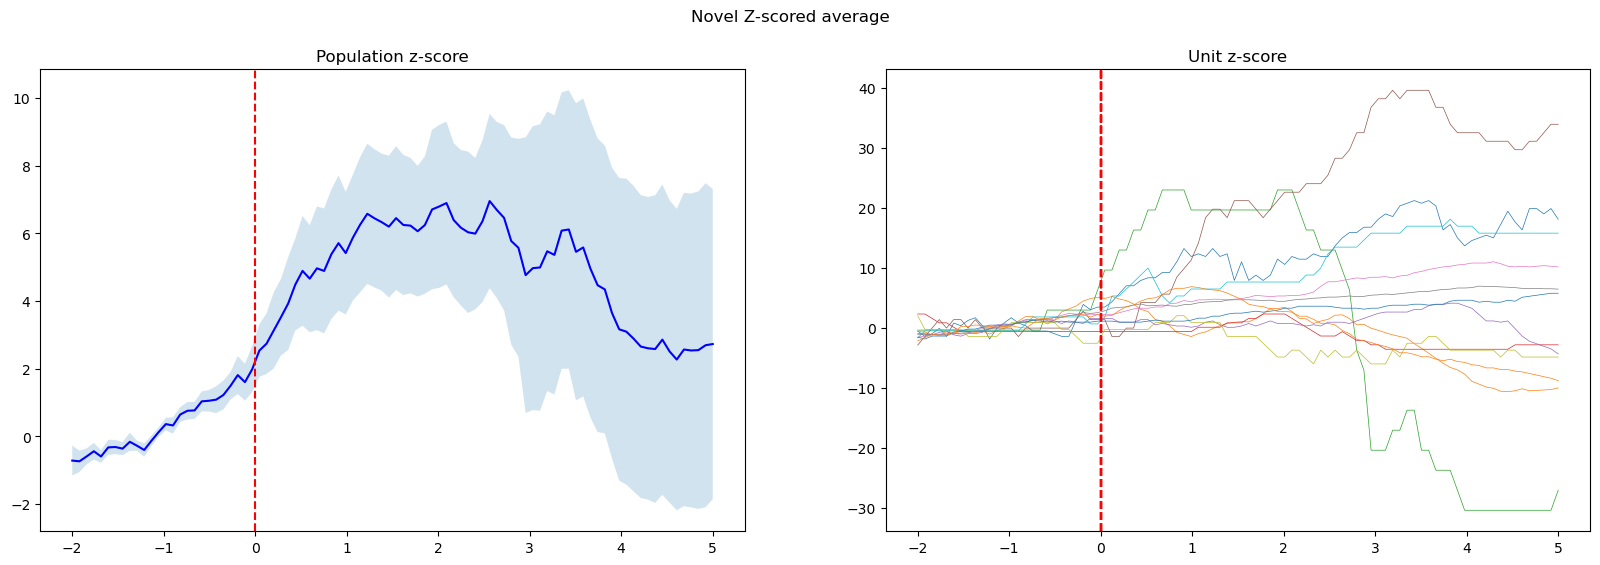

In [19]:
zscored_novel = phase3_timebin_tester.get_zscore('novel', 2, 5)
phase3_timebin_tester.get_zcore_plot(zscored_novel, 2, 5, 'Novel')

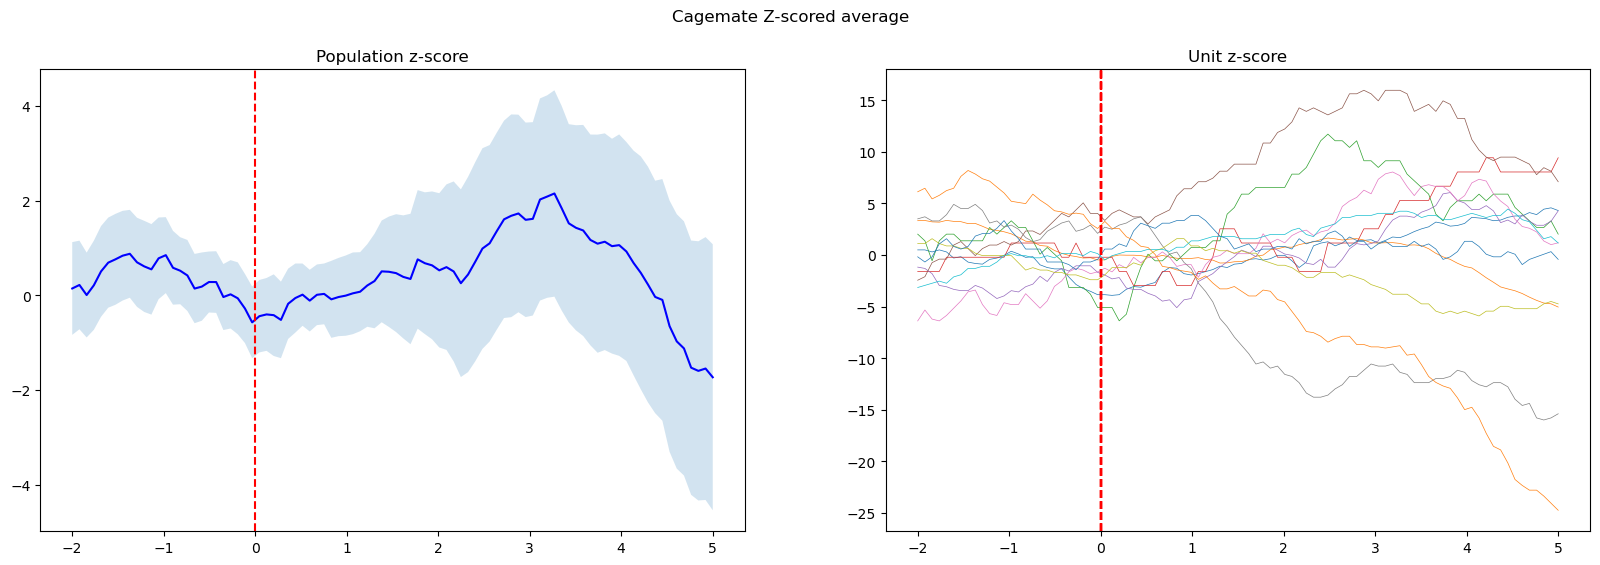

In [20]:
zscored_cagemate = phase3_timebin_tester.get_zscore('cagemate', 2, 5)
phase3_timebin_tester.get_zcore_plot(zscored_cagemate, 2, 5, 'Cagemate')

In [21]:
phase3_timebin_tester.PCA_trajectories(5, 2)

In [22]:
phase3_timebin_tester.PCA_matrix.shape

(280, 3)

IndexError: index 699 is out of bounds for axis 0 with size 280

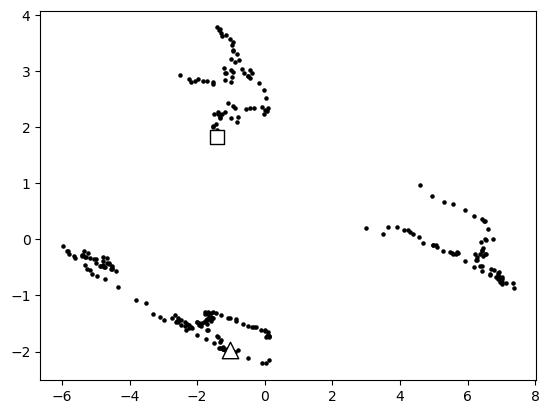

In [23]:

plt.scatter(phase3_timebin_tester.PCA_matrix[0:699,0], phase3_timebin_tester.PCA_matrix[0:699,1], c = 'k', label = 'novel', s = 5)
plt.scatter(phase3_timebin_tester.PCA_matrix[0,0], phase3_timebin_tester.PCA_matrix[0,1], marker = 's', s = 100, c = 'w', edgecolors='k' )
plt.scatter(phase3_timebin_tester.PCA_matrix[199,0], phase3_timebin_tester.PCA_matrix[199,1], marker = '^', s = 140, c = 'w', edgecolors='k')
plt.scatter(phase3_timebin_tester.PCA_matrix[699,0], phase3_timebin_tester.PCA_matrix[699,1], marker = 'o', s = 100, c = 'w', edgecolors='k')
plt.scatter(phase3_timebin_tester.PCA_matrix[700:1399,0], phase3_timebin_tester.PCA_matrix[700:1399,1], c='b', label = 'familiar', s = 5)
plt.scatter(phase3_timebin_tester.PCA_matrix[700,0], phase3_timebin_tester.PCA_matrix[700,1], marker = 's', s = 100, c = 'w', edgecolors='b')
plt.scatter(phase3_timebin_tester.PCA_matrix[899,0], phase3_timebin_tester.PCA_matrix[899,1], marker = '^',  s = 140, c = 'w', edgecolors='b')
plt.scatter(phase3_timebin_tester.PCA_matrix[1399,0], phase3_timebin_tester.PCA_matrix[1399,1], marker = 'o',  s = 100, c = 'w', edgecolors='b')
plt.scatter(phase3_timebin_tester.PCA_matrix[1400:2099,0], phase3_timebin_tester.PCA_matrix[1400:2099,1], c = 'r', label = 'cagemate', s = 5)
plt.scatter(phase3_timebin_tester.PCA_matrix[1400,0], phase3_timebin_tester.PCA_matrix[1400,1], marker = 's',  s = 100, c = 'w', edgecolors='r')
plt.scatter(phase3_timebin_tester.PCA_matrix[1599,0], phase3_timebin_tester.PCA_matrix[1599,1], marker = '^',  s = 140, c = 'w', edgecolors='r')
plt.scatter(phase3_timebin_tester.PCA_matrix[2099,0], phase3_timebin_tester.PCA_matrix[2099,1], marker = 'o',  s = 100, c = 'w', edgecolors='r')
plt.scatter(phase3_timebin_tester.PCA_matrix[2100:2799,0], phase3_timebin_tester.PCA_matrix[2100:2799,1], c='g', label = 'empty', s = 5)
plt.scatter(phase3_timebin_tester.PCA_matrix[2100,0], phase3_timebin_tester.PCA_matrix[2100,1], marker = 's',  s = 100, c = 'w', edgecolors='g')
plt.scatter(phase3_timebin_tester.PCA_matrix[2399,0], phase3_timebin_tester.PCA_matrix[2399,1], marker = '^',  s = 140, c = 'w', edgecolors='g')
plt.scatter(phase3_timebin_tester.PCA_matrix[2799,0], phase3_timebin_tester.PCA_matrix[2799,1], marker = 'o', s = 100, c = 'w', edgecolors='g')
plt.legend()
plt.title('Square = start, triangle = onset, circle = end')
plt.show()

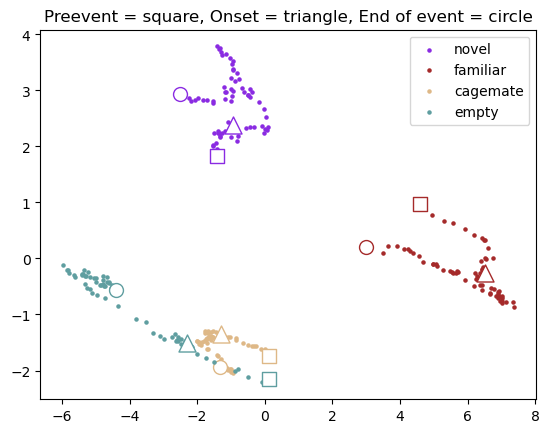

In [ ]:
phase3_timebin_tester.PCA_EDA_plot()

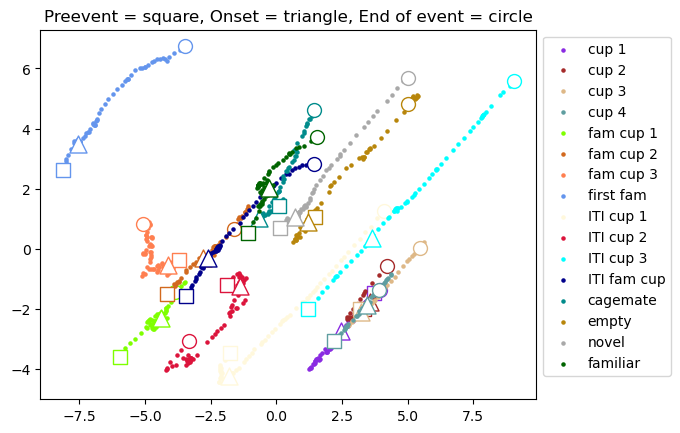

In [28]:
analysis_1_1.PCA_trajectories(5, 2)
analysis_1_1.PCA_EDA_plot()